# Beijing Air-Quality Time Series Project
### Modeling Time Series

by Dolci Sanders and Paul Torres



In [1]:
# Pandas/Data readers/ etc 
import pandas as pd
import numpy as np
import pickle

# Visuals 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Stats Models
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots

# PMDARIMA
import pmdarima
from pmdarima import auto_arima    # for determining ARIMA orders

# Facebook Prophet 
from fbprophet import Prophet

# Metrics
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tools.eval_measures import mse




import warnings
warnings.filterwarnings("ignore")

# Styling Guide 
plt.style.use('fivethirtyeight')
sns.set_palette(sns.diverging_palette(250,700, s= 70 , l= 10, n= 12))



Importing plotly failed. Interactive plots will not work.


## Read in pickle, check index for date time

In [2]:
train = pd.read_pickle('PKL/train.pkl')
test = pd.read_pickle('PKL/test.pkl')
time = pd.read_pickle('PKL/time.pkl')

In [3]:
#train.index = pd.DatetimeIndex(train.index).to_period('D')
#test.index = pd.DatetimeIndex(test.index).to_period('D')

### ACF and PACF 

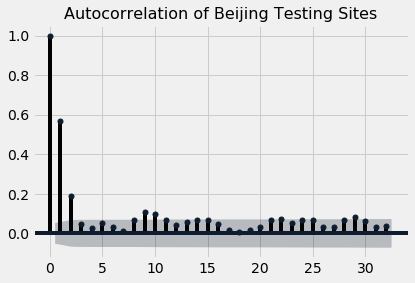

In [4]:
plot_acf(time['PM2.5'][:-1], alpha=.05)
plt.title('Autocorrelation of Beijing Testing Sites', fontsize = 16);

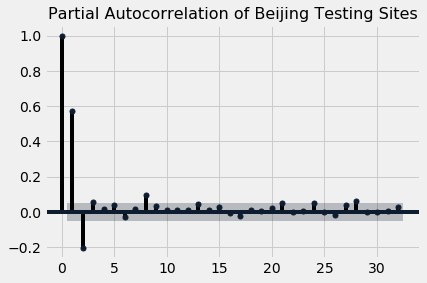

In [5]:
plot_pacf(time['PM2.5'][:-1], alpha=.05)
plt.title('Partial Autocorrelation of Beijing Testing Sites', fontsize = 16);

## Find Ideal Parameters and then run models:

### Auto Arima 

We used auto arima to look for the best parameters. We capped our search at 3 for p and q values.
We found the best recipes wer (1,0,1) and (0,0,0) so we tried those in both ARIMA and SARIMAX. 

--oddly enough the number given when using the log of train preformed worse than when we ran our stepwise fit without the log, so we kept the best preforming models. 

In [6]:
stepwise_fit = auto_arima(train['PM2.5'], start_p=0, start_q=0,
                         max_p=3, max_q=3, m=12,
                         seasonal=True,
                         d=None, trace=True,
                         error_action='ignore',   # we don't want to know if an order does not work
                         suppress_warnings=True,  # we don't want convergence warnings
                         stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=12619.683, Time=1.87 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=12620.583, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=12183.206, Time=0.90 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=12188.912, Time=1.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=13621.719, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=12181.777, Time=0.10 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=12183.237, Time=0.34 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=12185.222, Time=0.76 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=12138.074, Time=0.11 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=12139.922, Time=0.56 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=12139.927, Time=0.46 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=12141.922, Time=1.04 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=12138.328, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=12138.343, Time=0.95 sec
 ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1121
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -6064.561
Date:                Fri, 11 Sep 2020   AIC                          12137.123
Time:                        02:06:56   BIC                          12157.211
Sample:                             0   HQIC                         12144.715
                               - 1121                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     52.1073      4.837     10.772      0.000      42.626      61.588
ar.L1          0.3551      0.035     10.131      0.000       0.286       0.424
ma.L1          0.3352      0.040      8.440      0.000       0.257       0.413
sigma2      2926.6341     80.150     36.515      0.000    2769.543    3083.725
===================================================================================
Ljung-Box (Q):                       37.49   Jarque-Bera (JB):               767.87
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.76
Prob(H) (two-sided):                  0.97   Kurtosis:                         6.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Above is the stepwise fit of auto arima (train)
- ### Best model:  ARIMA(1,0,1)(0,0,0)[12] intercept

## Below is the stepwise fit of auto arima (log of train)
- ### Best model:  ARIMA(0,1,1)(0,0,0)[12]    


In [70]:
stepwise_fit = auto_arima(np.log(train['PM2.5']), start_p=0, start_q=0,
                         max_p=3, max_q=3, m=12,
                         seasonal=True,
                         d=None, trace=True,
                         error_action='ignore',   
                         suppress_warnings=True,  
                         stepwise=True)           

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-76.745, Time=1.16 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-79.070, Time=0.23 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-90.267, Time=0.67 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-110.494, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-81.068, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-111.633, Time=0.30 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-110.519, Time=0.65 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=-108.639, Time=3.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-91.394, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=1.51 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=-113.632, Time=0.11 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=-112.518, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[12]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1121
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  58.816
Date:                Fri, 11 Sep 2020   AIC                           -113.632
Time:                        08:19:29   BIC                           -103.590
Sample:                             0   HQIC                          -109.836
                               - 1121                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3161      0.029    -10.777      0.000      -0.374      -0.259
sigma2         0.0527      0.002     32.067      0.000       0.049       0.056
===================================================================================
Ljung-Box (Q):                      213.51   Jarque-Bera (JB):               299.14
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                            -0.94
Prob(H) (two-sided):                  0.96   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Arima using the log of PM2.5 
## (1,0,1)

- ARIMA(1,0,1) MSE Error: 0.6443607375932078
- ARIMA(1,0,1) RMSE Error: 0.8027208341591787

In [12]:
train['PM2.5'] = np.log(train['PM2.5'])
test['PM2.5'] = np.log(test['PM2.5'])

In [13]:
# keeping the same order, but using the log 
model_arima_log = ARIMA(train['PM2.5'],order=(1,0,1))
results = model_arima_log.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  PM2.5   No. Observations:                 1121
Model:                     ARMA(1, 1)   Log Likelihood               -1227.306
Method:                       css-mle   S.D. of innovations              0.723
Date:                Fri, 11 Sep 2020   AIC                           2462.612
Time:                        02:07:01   BIC                           2482.700
Sample:                    03-01-2013   HQIC                          2470.204
                         - 03-25-2016                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.0504      0.042     95.664      0.000       3.967       4.133
ar.L1.PM2.5     0.3380      0.046      7.415      0.000       0.249       0.427
ma.L1.PM2.5     0.2987      0.044      6.724      0.000       0.212       0.386
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.9583           +0.0000j            2.9583            0.0000
MA.1           -3.3480           +0.0000j            3.3480            0.5000
-----------------------------------------------------------------------------
"""

In [14]:
# Get predicted values

start=len(train)
end=len(train)+len(test)-1
predictions_arima = results.predict(start=start, end=end, dynamic=False).rename('arima(1,0,1) Predictions')

In [15]:
error = mean_squared_error(test['PM2.5'], predictions_arima)
print(f'ARIMA(1,0,1) MSE Error: {error:18}')

error = rmse(test['PM2.5'], predictions_arima)
print(f'ARIMA(1,01) RMSE Error: {error:18}')

ARIMA(1,0,1) MSE Error: 0.6443607375932078
ARIMA(1,01) RMSE Error: 0.8027208341591787


In [16]:
predictions_arima.head()

2016-03-26    3.444474
2016-03-27    3.845562
2016-03-28    3.981143
2016-03-29    4.026973
2016-03-30    4.042465
Freq: D, Name: arima(1,0,1) Predictions, dtype: float64

In [17]:
pred= predictions_arima.reset_index()
type(pred)

pred["Date"] = pd.to_datetime(pred["index"])
pred = pred.set_index('Date')

pred = pred.rename(columns={'arima(1,0,1) Predictions': 'Predicted PM2.5'})
pred = pred.drop(columns =['index'])
pred.head()

,Predicted PM2.5
Date,
2016-03-26,3.444474
2016-03-27,3.845562
2016-03-28,3.981143
2016-03-29,4.026973
2016-03-30,4.042465


In [18]:
time2 = time = pd.read_pickle('PKL/time.pkl')
time2['PM2.5'] = np.log(time2['PM2.5'])

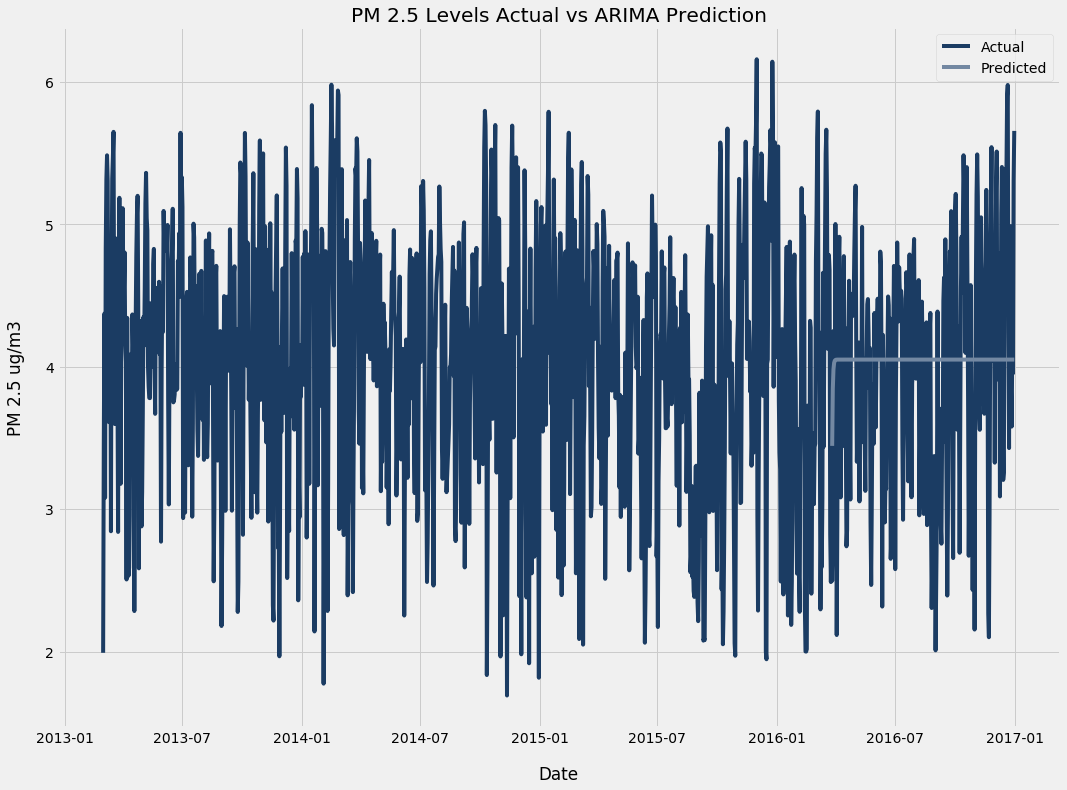

In [19]:
plt.style.use('fivethirtyeight')
sns.set_palette(sns.diverging_palette(250,700, s= 80 , l= 25, n= 6))
fig, ax = plt.subplots(figsize=(16, 12))

sns.lineplot(y = 'PM2.5', x = time2.index, data = time2, label = 'Actual')
sns.lineplot(y = 'Predicted PM2.5', x = pred.index, data = pred, label = 'Predicted')
plt.title('PM 2.5 Levels Actual vs ARIMA Prediction')
plt.xlabel('Date', labelpad=20)
plt.ylabel('PM 2.5 ug/m3', labelpad=20)
plt.legend()
plt.show()
fig.savefig('PNG/ARIMA.png', bbox_inches= 'tight', padding_inches = 4, transparent = True )


## Running SARIMAX using Log PM2.5
## (1,0,1)
- SARIMAX(1,0,1) MSE Error: 12.386112862104985
- SARIMAX(1,0,1) RMSE Error: 3.5193909788633864

In [20]:
model_SARIMAX = SARIMAX(train['PM2.5'],order=(1,0,1))
results = model_SARIMAX.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  PM2.5   No. Observations:                 1121
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1381.647
Date:                Fri, 11 Sep 2020   AIC                           2769.294
Time:                        02:07:03   BIC                           2784.360
Sample:                    03-01-2013   HQIC                          2774.988
                         - 03-25-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9856      0.006    179.039      0.000       0.975       0.996
ma.L1         -0.1735      0.032     -5.338      0.000      -0.237      -0.110
sigma2         0.6868      0.028     24.113      0.000       0.631       0.743
===================================================================================
Ljung-Box (Q):                      192.00   Jarque-Bera (JB):               162.13
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.79
Prob(H) (two-sided):                  0.38   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
# Get predicted values

start=len(train)
end=len(train)+len(test)-1
predictions_SARIMAX = results.predict(start=start, end=end, dynamic=False).rename('SARIMAX(1,0,1) Predictions')

In [22]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test['PM2.5'], predictions_SARIMAX)
print(f'SARIMAX(1,0,1) MSE Error: {error:18}')

from statsmodels.tools.eval_measures import rmse
error = rmse(test['PM2.5'], predictions_SARIMAX)
print(f'SARIMAX(1,0,1) RMSE Error: {error:18}')


SARIMAX(1,0,1) MSE Error: 12.386112862104985
SARIMAX(1,0,1) RMSE Error: 3.5193909788633864


## Facebook Prophet
Works best on daily predictions, so we will try to look at this. 
We must change the headers to 'ds' for the dates and the outcome is 'y'.

This model gives back a lot of data. It shows that the overall trend is going down, which is in line with all the research I was able to find online. Beijing has been very agressive about getting it's air pollution under control, and the data shows it is paying off. 


In [53]:
fbtrain = pd.read_pickle('PKL/train.pkl')
fbtest = pd.read_pickle('PKL/test.pkl')

In [54]:
#reset index
fbtrain.reset_index(inplace = True)

In [55]:
# Special format wanted for FB Prophet
fbtrain.rename(columns={"Date": "ds", "PM2.5": "y"}, inplace = True)

In [56]:
# We need to ensure this is the log to ensure stationarity 
fbtrain.y = np.log(fbtrain.y)

In [57]:
# FaceBook Prophet fitting

m = Prophet(daily_seasonality = True, changepoint_prior_scale=0.01)
m.fit(fbtrain)
future = m.make_future_dataframe(periods= 365, freq = 'D')
results = m.predict(future)

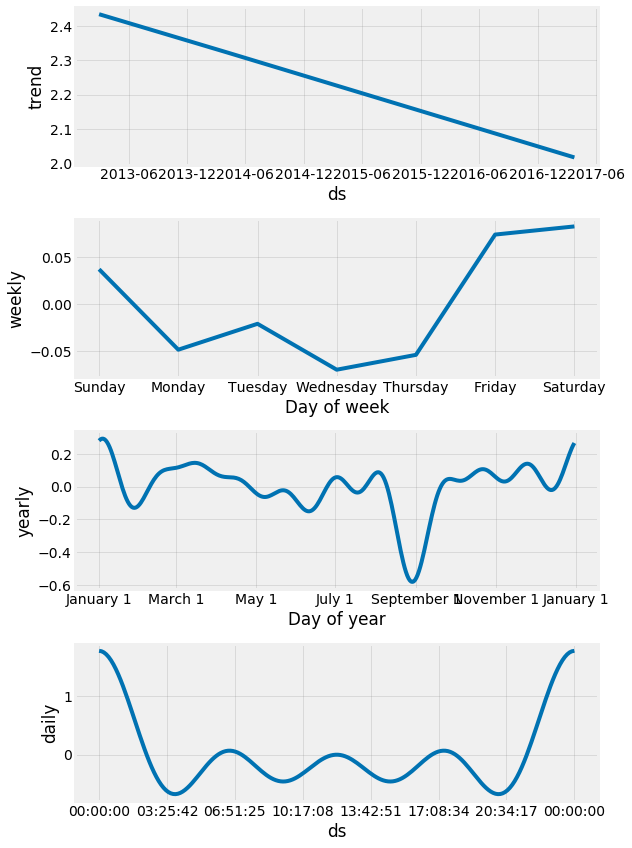

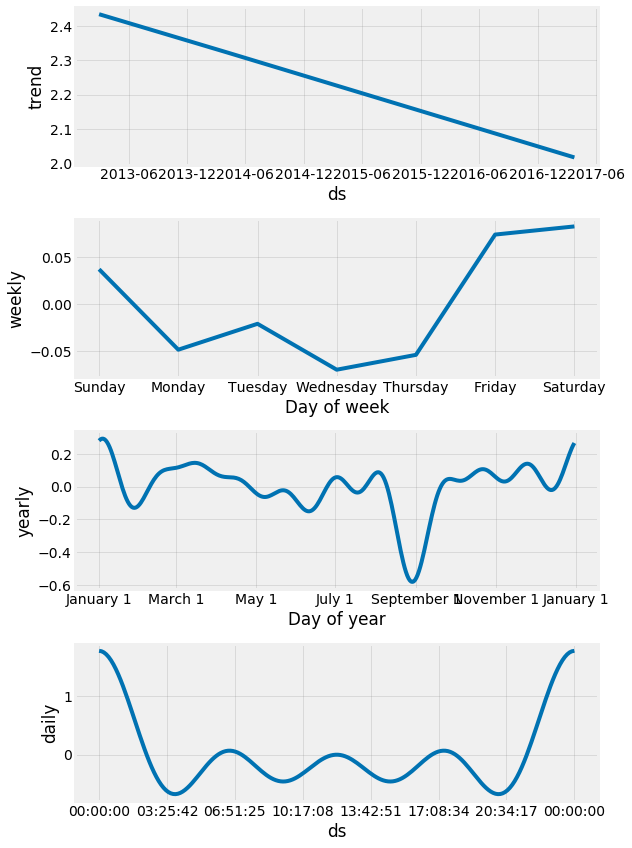

In [58]:
m.plot_components(results)

In [74]:
df = pd.DataFrame()
df['ds'] = results['ds']
df['yhat'] = results['yhat']

In [76]:
fbtest.shape

(281, 1)

In [77]:
df.rename(columns={"ds": "Date", "yhat": "PM2.5"}, inplace = True)
df = df.set_index('Date')

In [78]:
df = df.loc['2016-03-26':'2016-12-31']

In [79]:
df.shape

(281, 1)

In [80]:
fbtest['PM2.5'] = np.log(fbtest['PM2.5'])
time = pd.read_pickle('PKL/time.pkl')
time['PM2.5'] = np.log(time['PM2.5'])

## Facebook Prophet Prediction

Looking at the graph here, we can see the predicted value looks pretty good. 
It may trend lower, but that matches what is happening in the present day. 

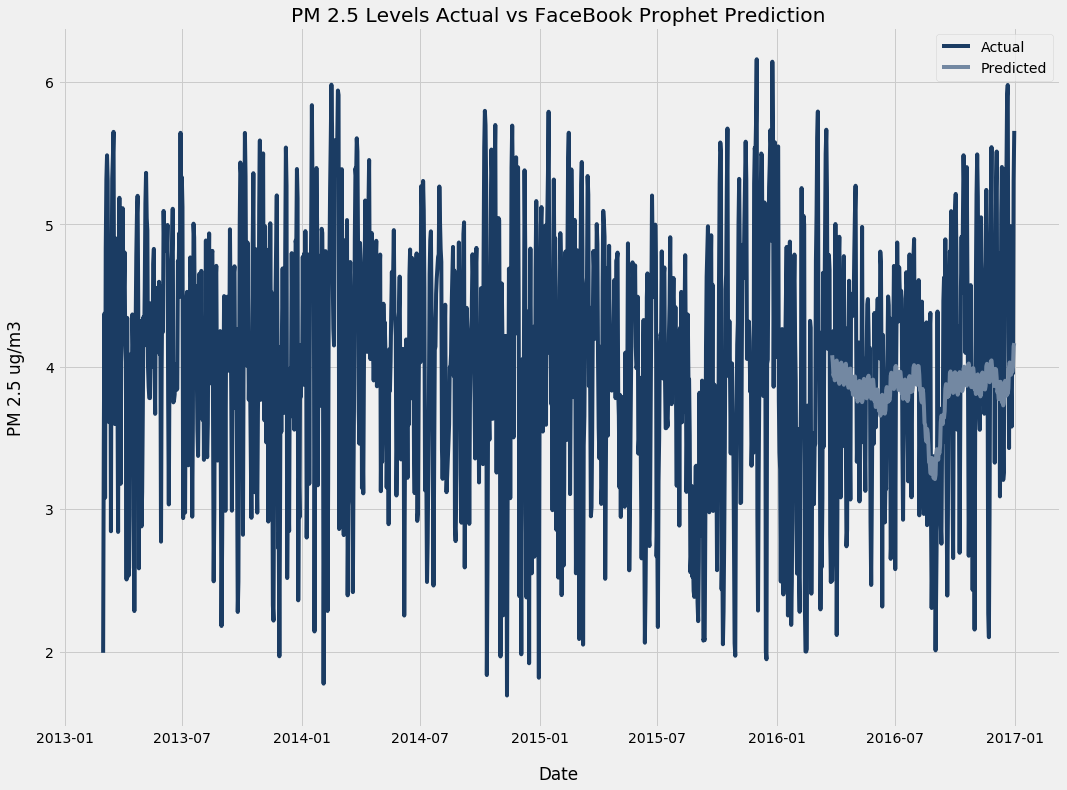

In [81]:
# Styling Guide 
plt.style.use('fivethirtyeight')
sns.set_palette(sns.diverging_palette(250,700, s= 80 , l= 25, n= 6))

fig, ax = plt.subplots(figsize=(16, 12))
sns.lineplot(y = 'PM2.5', x = time.index, data = time, label = 'Actual')
sns.lineplot(y = 'PM2.5', x = df.index, data = df, label = 'Predicted')
plt.title('PM 2.5 Levels Actual vs FaceBook Prophet Prediction')
plt.xlabel('Date', labelpad=20)
plt.ylabel('PM 2.5 ug/m3', labelpad=20)
plt.legend()
plt.show()

fig.savefig('PNG/FaceBookProphet2.png', bbox_inches= 'tight', padding_inches = 4, transparent = True )

In [98]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')

INFO:fbprophet:Making 1 forecasts with cutoffs between 2015-03-26 00:00:00 and 2015-03-26 00:00:00


In [99]:
df_cv.head()
df_cv = df_cv.loc['2016-03-26':'2016-12-31']

In [97]:
cutoffs = pd.to_datetime(['2015-06-01'])
df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='365 days')

In [100]:
df_p = performance_metrics(df_cv, rolling_window=7)

## RMSE MSE Scores

We can see here that the scores are similar, but both show that the farther away the prediction is, the higher the RMSE/MSE Score with exception to around day 100. This could be because some of the seasonaility help explain those days better, and because we have daily seasonality built into FB Prophet, it works really well for daily predictions. 

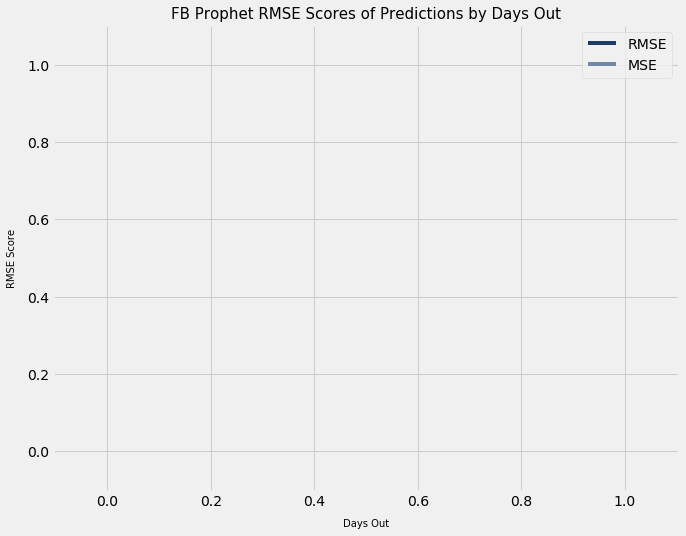

In [101]:
from fbprophet.diagnostics import performance_metrics

fig, ax = plt.subplots(figsize=(10, 8))
df_p = performance_metrics(df_cv)
plt.plot(df_p['rmse'], label = 'RMSE')
plt.plot(df_p['mse'], label = 'MSE')
plt.title('FB Prophet RMSE Scores of Predictions by Days Out', fontsize = 15)
plt.xlabel('Days Out', fontsize = 10, labelpad = 10)
plt.ylabel('RMSE Score', fontsize = 10, labelpad = 10)
plt.legend();

fig.savefig('PNG/FBP_RMSE_MSE.png', bbox_inches= 'tight', padding_inches = 4, transparent = True )

In [69]:
print('FBP MSE: ', df_p.mse.mean())
print('FBP RMSE: ',df_p.rmse.mean())

FBP MSE:  1.0053470330535705
FBP RMSE:  0.971096519700855
